## Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset provided in this exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

The objective is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, the goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [158]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from pandas_profiling import ProfileReport

from imblearn.combine import SMOTETomek
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score,accuracy_score,recall_score,confusion_matrix
import xgboost as xgb

# load in the data
train_data = pd.read_csv('training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In the dataset, we can consider that the 'Promotion' column takes 'No' for the control group, and 'Yes' for the experimental group. The 'purchase' column takes value of 0 for no purchase, and 1 for purchase.

### Hypothesis Test for Invariant Metric
First of all, we should check that the number of Promotions given to each group is similar. It's important to check the invariant metrics as a prerequisite so that our inferences on the evaluation metrics are founded on solid ground. If we find that the two groups are imbalanced on the invariant metric, then this will require us to look carefully at how the promotions were split so that any sources of bias are accounted for.

In this case, we want to do a two-sided hypothesis test on the proportion of promotions assigned to one of our conditions. 

#### Test setup
Null Hypothesis: Number of users given Promotion is same as number of users not given promotion

Alternate Hypothesis: Number of users given Promotion is different than number of users not given promotion

In [159]:
# get the purchase count for control group
con=train_data[train_data.Promotion=='No'].Promotion.count()

# get the purchase count for experiment group
exp=train_data[train_data.Promotion=='Yes'].Promotion.count()

# compute observed difference in groups
obs_diff=exp-con
print('obs_diff:',obs_diff)

obs_diff: 194


In [160]:
## create sampling distribution of difference in count with boostrapping
diff=[]
for i in range(1000):
    df=train_data.sample(train_data.shape[0],replace=True)
    con=df[df.Promotion=='No'].Promotion.count()
    exp=df[df.Promotion=='Yes'].Promotion.count()
    diff.append(exp-con)

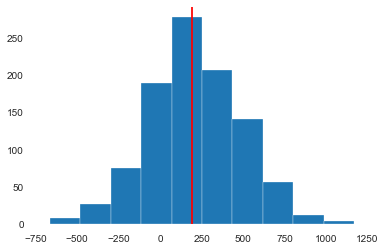

In [161]:
# plot sampling distribution
plt.hist(diff);

# plot line for observed statistic
plt.axvline(obs_diff,c='R');

In [162]:
# compute 95% confidence interval
np.percentile(diff,2.5),np.percentile(diff,97.5)

(-356.19999999999993, 772.0999999999999)

In [163]:
# simulate distribution under the null hypothesis
null_vals=np.random.normal(0,np.std(diff),len(diff))

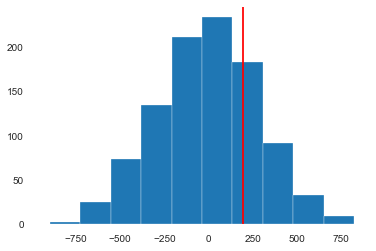

In [164]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff,c='R');

In [165]:
# compute p value: Calculate proportion of the simulated draws that are larger than the sample mean.
null_mean=0

# probability of a statistic higher than observed
prob_more_extreme_high = (null_vals > obs_diff).mean()
    
# probability a statistic is more extreme lower
prob_more_extreme_low = (null_mean - (obs_diff - null_mean) > null_vals).mean()

pval = prob_more_extreme_low + prob_more_extreme_high
pval


0.495

### Conclusion
Since P value is more than .05, we fail to reject the null hypothesis. it means that the number of users in both groups is similar.

### Hypothesis Test for Evaluation Metric

After performing our checks on the invariant metric, we can move on to performing a hypothesis test on the evaluation metric: the purchase ratio. In this case, we want to see that the experimental group has a significantly larger purchase ratio than the control group, a one-tailed test.

#### Test setup
Null Hypothesis: Purchase rate is same when Promotion is not given to users

Alternate Hypothesis: Purchase rate is higher when Promotion is given to users

In [166]:
# get the purchase count for control group
con=train_data[(train_data.Promotion=='No') & (train_data.purchase==1)].Promotion.count()

# get the purchase count for experiment group
exp=train_data[(train_data.Promotion=='Yes') & (train_data.purchase==1)].Promotion.count()

# compute observed difference in groups
obs_diff=exp-con
print('obs_diff:',obs_diff)

obs_diff: 402


In [167]:
## create sampling distribution of difference in count with boostrapping
diff=[]
for i in range(1000):
    df=train_data.sample(train_data.shape[0],replace=True)
    con=df[(df.Promotion=='No') & (df.purchase==1)].Promotion.count()
    exp=df[(df.Promotion=='Yes') & (df.purchase==1)].Promotion.count()
    diff.append(exp-con)

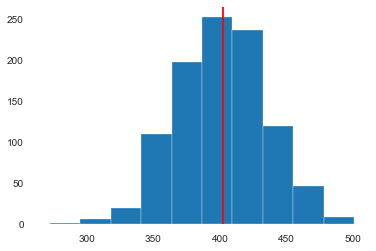

In [168]:
# plot sampling distribution
plt.hist(diff);

# plot line for observed statistic
plt.axvline(obs_diff,c='R');

In [169]:
# compute 95% confidence interval
np.percentile(diff,2.5),np.percentile(diff,97.5)

(337.0, 466.0)

In [170]:
# simulate distribution under the null hypothesis
null_vals=np.random.normal(0,np.std(diff),len(diff))

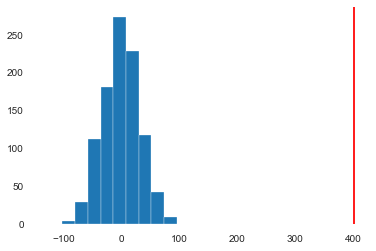

In [171]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff,c='R');

In [172]:
# compute p value: Calculate proportion of the simulated draws that are larger than the sample mean.
(null_vals>obs_diff).mean()

0.0

### Conclusion
Since P value is less than .05, we reject the null hypothesis. it means that purchase rate in experiment group is statistically significant than control group.

### Data Exploration

In [173]:
train_data.Promotion.value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [174]:
train_data.purchase.value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

In [175]:
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [176]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [177]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


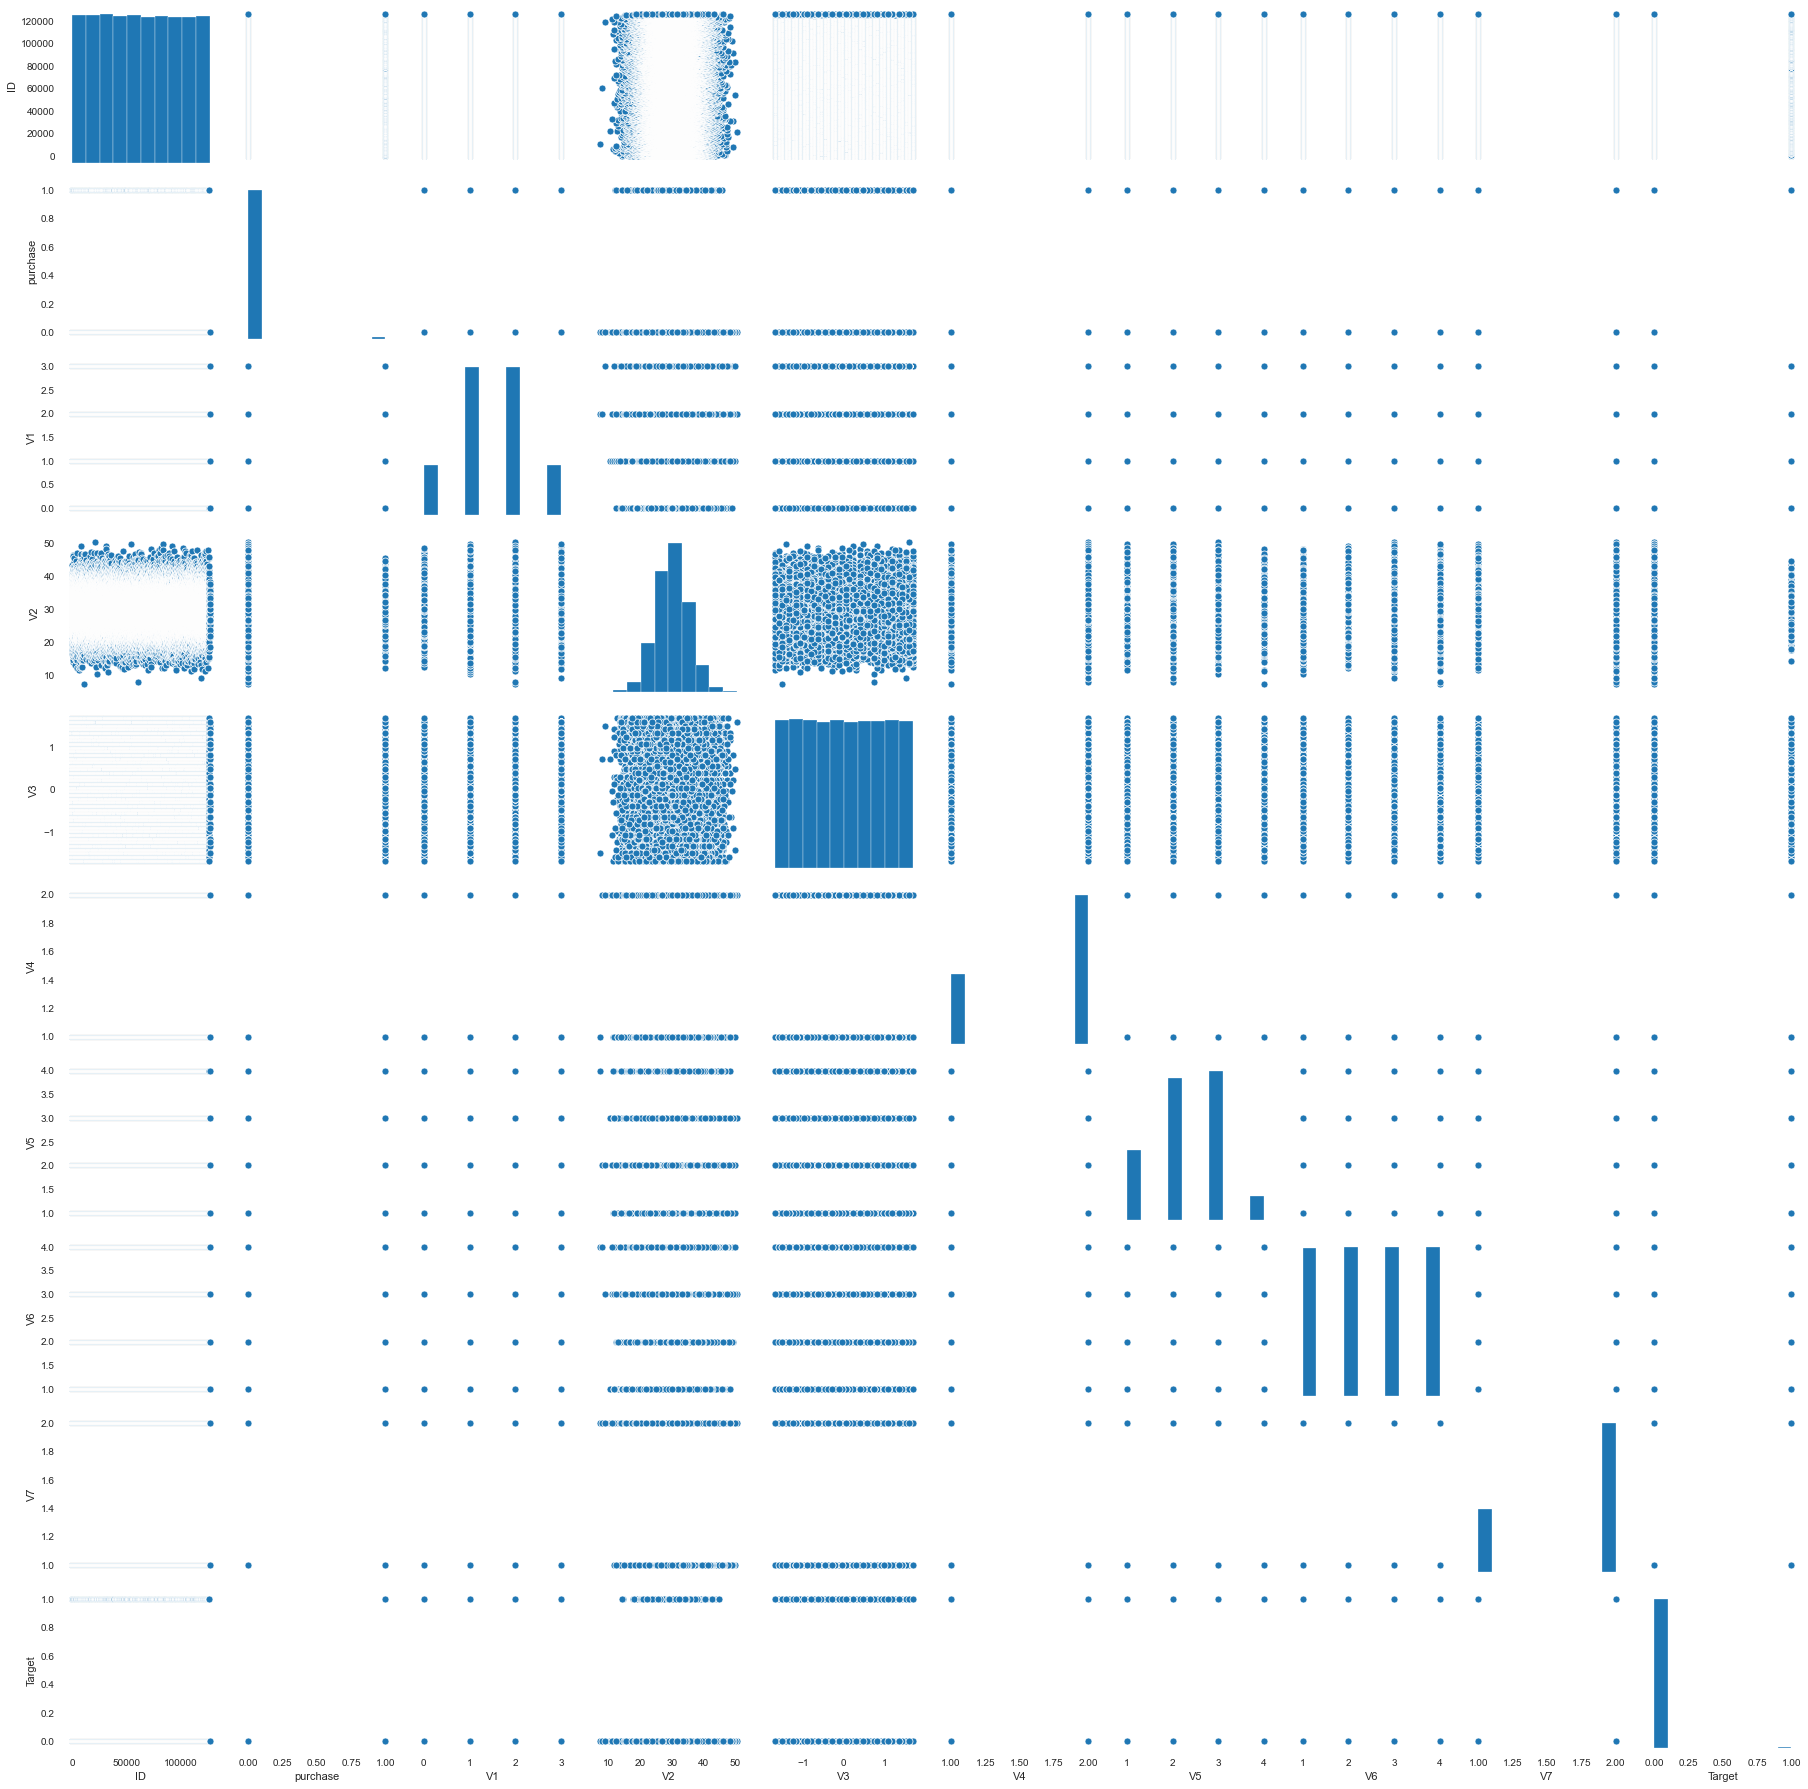

In [183]:
sns.pairplot(train_data);

### Present Incremental Response Rate

In [178]:
exp=train_data[train_data.Promotion=="Yes"].purchase.mean()
con=train_data[train_data.Promotion=="No"].purchase.mean()
print('IRR:',exp-con)

IRR: 0.009454547819772702


### Present Net Incremental Revenue

In [179]:
Purch_Treat=train_data[train_data.Promotion=="Yes"].purchase.sum()
Cust_Treat=train_data[train_data.Promotion=="Yes"].shape[0]
Purch_Control=train_data[train_data.Promotion=="No"].purchase.sum()
print('NIR:',(10*Purch_Treat - 0.15*Cust_Treat) - 10*Purch_Control)

NIR: -2334.5999999999995


In [180]:
profile=ProfileReport(train_data,title="Starbucks Profiling Report",explorative=True)
profile.to_file("Starbucks.html")

### Approach for creating Machine Learning Model.
In this approach, we will assign labels of 1 to those who received the promotions and made purchases, and labels of 0 to everyone else. In other words, we want the model to find the individuals who are likely to purchase only after they received a promotion.

This is a simple model that generated IRR 0.0191 of and NIR of \$237.75. This model actually outperformed the Starbuck's model for this dataset, which was an irr of 1.88\% and an nlr of \\$189.45.

In [181]:
# Creating target variable
train_data['Target']=99
for i in range(train_data.shape[0]):
    if (train_data['Promotion'][i]=="Yes") & (train_data['purchase'][i]==1):
        train_data['Target'][i]=1
    else:
        train_data['Target'][i]=0

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [184]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,Target
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,0


In [182]:
train_data['Target'].value_counts()

0    83813
1      721
Name: Target, dtype: int64

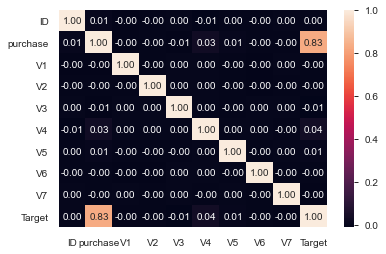

In [187]:
# Correlation matrix
sns.heatmap(train_data.corr(),annot=True,fmt='.2f');

In [202]:
# split data into training set and validation set
train, valid = train_test_split(train_data, test_size=0.2,random_state=42)

In [203]:
# generate features and labels
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

Y_train = train['Target']
X_train = train[features]

Y_valid = valid['Target']
X_valid = valid[features]

In [206]:
# Upsample only the train dataset with SMOTE to remove skewness in data
sm = SMOTETomek(random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [212]:
# Checking the data distribution after upsampling
unique, counts = np.unique(y_upsample, return_counts=True)
dict(zip(unique, counts))

{0: 83637, 1: 83637}

In [214]:
# Train Xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.74659	validation_1-auc:0.56087
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.77379	validation_1-auc:0.56746
[2]	validation_0-auc:0.77635	validation_1-auc:0.56671
[3]	validation_0-auc:0.78002	validation_1-auc:0.56719
[4]	validation_0-auc:0.79589	validation_1-auc:0.57263
[5]	validation_0-auc:0.80358	validation_1-auc:0.57137
[6]	validation_0-auc:0.80473	validation_1-auc:0.57410
[7]	validation_0-auc:0.81960	validation_1-auc:0.57081
[8]	validation_0-auc:0.82961	validation_1-auc:0.56875
[9]	validation_0-auc:0.83303	validation_1-auc:0.56868
[10]	validation_0-auc:0.84103	validation_1-auc:0.56752
[11]	validation_0-auc:0.84137	validation_1-auc:0.57240
[12]	validation_0-auc:0.84637	validation_1-auc:0.57187
[13]	validation_0-auc:0.85280	validation_1-auc:0.57179
[14]	validation_0-auc:0.85758	validation_1-auc:0.57247
[15]	validation_0-auc:0.8629

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

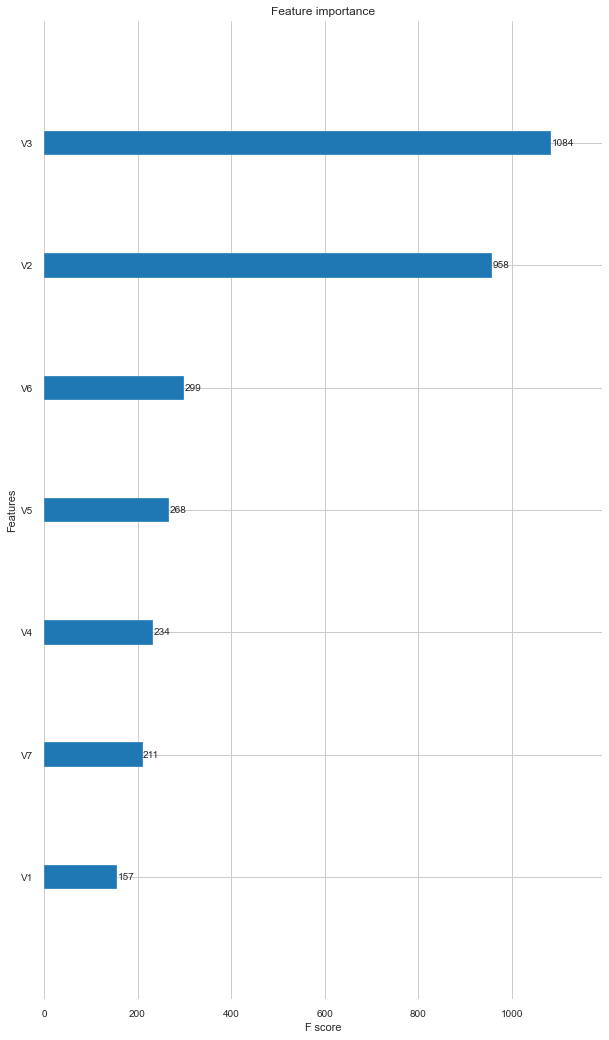

In [215]:
# check which features are important
from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [216]:
# Displaying the best parameters selected by Grid Search
cv.best_params_

{'max_depth': 25, 'min_samples_split': 2}

In [217]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
       
    y_pred=model.predict(df)

    promotion=[]
    for i in range(len(y_pred)):
        if y_pred[i]==0:
            promotion.append("No")
        else:
            promotion.append("Yes")
    
    promotion=np.array(promotion)
    return promotion

In [218]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0191.

Your nir with this strategy is 237.75.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019137928806694574, 237.75)

### Result
The model generated a higher NIR (Net Incremental Revenue) of $237.75